In [403]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf
from window_generator import WindowGenerator
from seaborn import violinplot

np.set_printoptions(precision = 4)

In [19]:
def queryRangePostCode(df_power, consumption_range_kwh = 2000, post_code = "81737", rank_range = None) -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        if rank_range != None:
            res = res.loc[(res["rank"] >= rank_range[0]) & (res["rank"] <= rank_range[1])]

        #Aggregating for mean household prices per day 
        res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

In [ ]:
path_clean_power = "./data/clean_competitor_market_prices_power.csv"
path_master_market = "./data/master_market.csv"

dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64, "post_code": str, "rank": np.float16}
usecols = [name for name, _ in dtypes.items()]

household = pd.read_csv(path_clean_power, usecols=usecols, dtype = dtypes)
market = pd.read_csv(path_master_market, header = [0], parse_dates=["date"]).drop("Unnamed: 0", axis=1)

market.set_index("date", inplace = True)
market.interpolate(method = "time", axis = 0, inplace = True)
household["date_valid_to"].replace({"9999-12-31": "2022-10-15"}, inplace=True)
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])
postCodes = household.post_code.unique()
consRanges = household.consumption_range_kwh.unique()

In [469]:
df = queryRangePostCode(household, 3500, "12627", rank_range=[6,10])
input = df.join(market[["d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"]]/1000)
input.drop(["2022-10-14", "2022-10-15"], inplace=True)

In [100]:
input

,price_kwh,spot,d01,d02,M01,M02,M03,q01,q02,y01,y02
valid_range,,,,,,,,,,,
2021-08-14,0.292291,0.063369,0.06194,0.06760,0.09711,0.09955,0.10780,0.10326,0.10175,0.08447,0.07112
2021-08-15,0.292291,0.061945,0.06760,0.05739,0.09711,0.09955,0.10780,0.10326,0.10175,0.08447,0.07112
2021-08-16,0.292291,0.067600,0.05739,0.08208,0.09711,0.09955,0.10780,0.10326,0.10175,0.08447,0.07112
2021-08-17,0.292291,0.057392,0.07864,0.09236,0.09737,0.09948,0.10650,0.10263,0.10161,0.08476,0.07125
2021-08-18,0.292291,0.078643,0.09162,0.10767,0.09556,0.09778,0.10595,0.10142,0.10101,0.08413,0.07120
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-09,0.686795,0.146725,0.16209,0.25987,0.34489,0.39041,0.54793,0.48409,0.36300,0.42700,0.27000
2022-10-10,0.686795,0.162090,0.25987,0.30167,0.34489,0.39041,0.54793,0.48409,0.36300,0.42700,0.27000
2022-10-11,0.717755,0.259874,0.28254,0.25562,0.34531,0.38275,0.56462,0.50137,0.37100,0.43564,0.27000


In [105]:
norm_layer = tf.keras.layers.Normalization(axis = 1)
norm_layer.adapt(input)
norm_input = norm_layer(input)

In [102]:
norm_input

<tf.Tensor: shape=(426, 11), dtype=float32, numpy=
array([[-1.2409, -1.2597, -1.2744, ..., -0.9377, -1.0187, -1.0908],
       [-1.2409, -1.2714, -1.2279, ..., -0.9377, -1.0187, -1.0908],
       [-1.2409, -1.225 , -1.3118, ..., -0.9377, -1.0187, -1.0908],
       ...,
       [ 1.9879,  0.3544,  0.5382, ...,  0.4682,  1.3533,  1.5919],
       [ 2.5005,  0.5405,  0.3321, ...,  0.4326,  1.3422,  1.5649],
       [ 1.9144,  0.3345,  0.3583, ...,  0.3683,  1.2746,  1.5651]],
      dtype=float32)>

In [81]:
norm_input.numpy().shape

(300, 11)

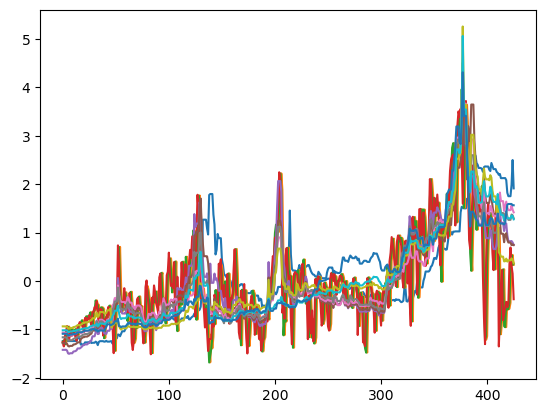

In [104]:
plt.plot(norm_input)

<AxesSubplot: xlabel='valid_range'>

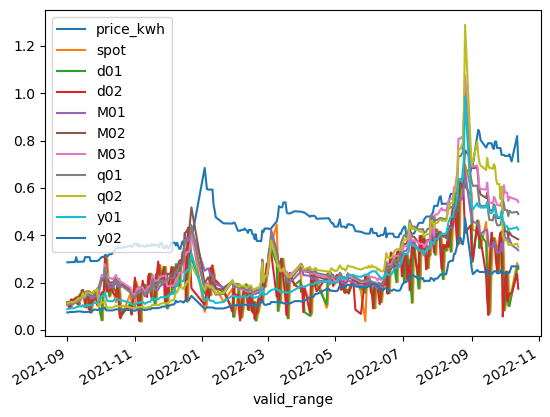

In [59]:
input.plot()

In [591]:
n = len(input)
train_df = input[:int(0.7*n)]
val_df = input[int(0.7*n):int(0.9*n)]
test_df = input[int(0.9*n):]

In [415]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(298, 11)
(85, 11)
(43, 11)


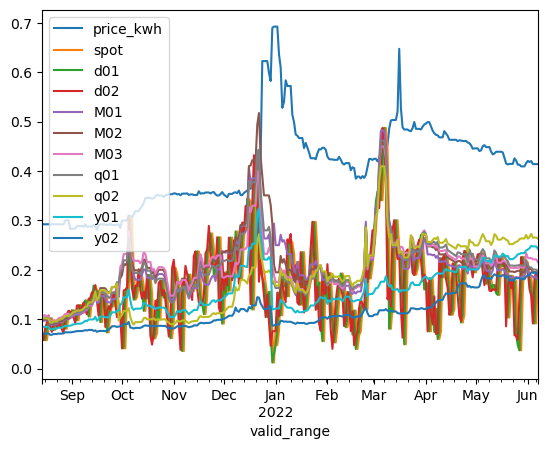

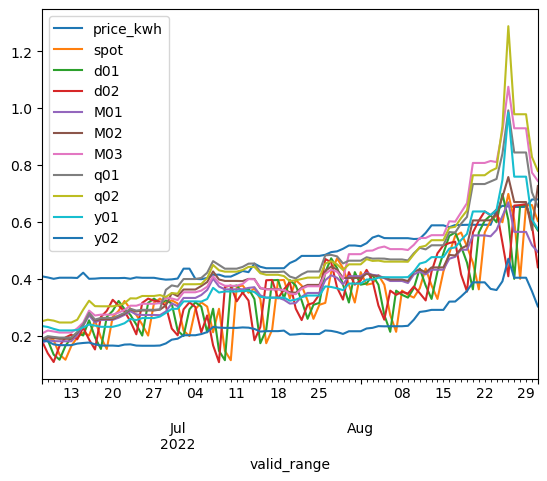

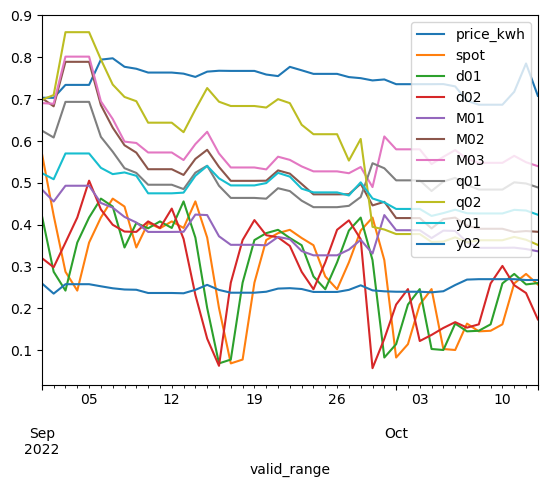

In [408]:
for df in [train_df, val_df, test_df]:
    df.plot()

In [592]:
mean = train_df.mean()
std = train_df.std()

train_df = (train_df - mean) / std
val_df = (val_df - mean) / std
test_df = (test_df - mean) / std

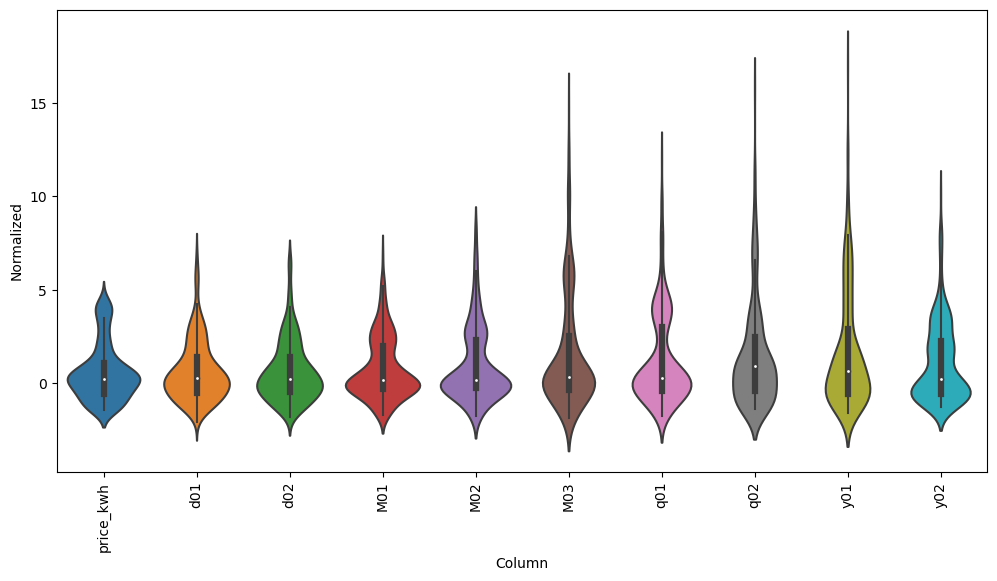

In [593]:
df_std = (input - mean) / std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(input.keys(), rotation=90)

# Baseline

In [594]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['price_kwh'], train_df=train_df, val_df=val_df, test_df=test_df)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['price_kwh']

In [595]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [596]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=1)

2/2 [==============================] - 0s 3ms/step - loss: 0.0608 - mean_squared_error: 0.0608


In [597]:
print(performance, val_performance)

{'Baseline': [0.060828596353530884, 0.060828596353530884]} {'Baseline': [0.018064197152853012, 0.018064197152853012]}


# Linear Model

In [598]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, activation = None)
])

In [599]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 10)
Output shape: (32, 1, 1)


In [600]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    verbose = 1)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=early_stopping, verbose = 0)
  return history

In [601]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 2ms/step - loss: 1.8645 - mean_squared_error: 1.8645


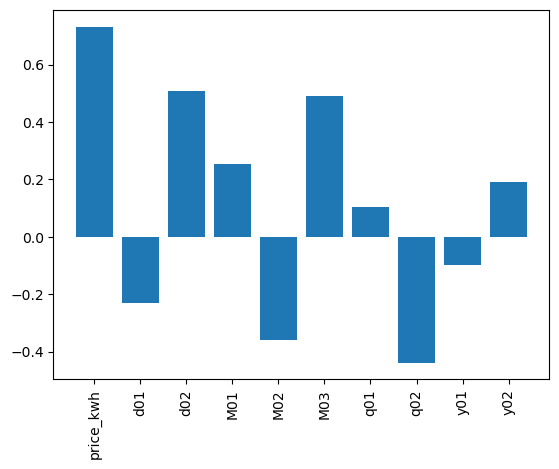

In [602]:
#Print weights of linear model
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [603]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 4: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.9508 - mean_squared_error: 0.9508


In [604]:
performance

{'Baseline': [0.060828596353530884, 0.060828596353530884],
 'Linear': [1.3846913576126099, 1.3846913576126099],
 'Dense': [0.5050022006034851, 0.5050022006034851]}

# Multi Step Dense

In [605]:
CONV_WIDTH = 10
my_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=CONV_WIDTH,
    shift=1,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

my_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 1  2  3  4  5  6  7  8  9 10]
Label column name(s): ['price_kwh']

In [606]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [607]:
print('Input shape:', my_window.example[0].shape)
print('Output shape:', multi_step_dense(my_window.example[0]).shape)


Input shape: (32, 10, 10)
Output shape: (32, 1, 1)


In [608]:
history = compile_and_fit(multi_step_dense, my_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(my_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(my_window.test, verbose=0)


Epoch 6: early stopping
3/3 [==============================] - 0s 17ms/step - loss: 0.3434 - mean_squared_error: 0.3434


In [609]:
performance

{'Baseline': [0.060828596353530884, 0.060828596353530884],
 'Linear': [1.3846913576126099, 1.3846913576126099],
 'Dense': [0.5050022006034851, 0.5050022006034851],
 'Multi step dense': [0.21361711621284485, 0.21361713111400604]}

# Convolutional Model

In [610]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [611]:
print("Conv model on `conv_window`")
print('Input shape:', my_window.example[0].shape)
print('Output shape:', conv_model(my_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 10, 10)
Output shape: (32, 1, 1)


In [612]:
history = compile_and_fit(conv_model, my_window)

val_performance['Conv'] = conv_model.evaluate(my_window.val)
performance['Conv'] = conv_model.evaluate(my_window.test, verbose=0)


Epoch 8: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 0.3217 - mean_squared_error: 0.3217


In [613]:
performance

{'Baseline': [0.060828596353530884, 0.060828596353530884],
 'Linear': [1.3846913576126099, 1.3846913576126099],
 'Dense': [0.5050022006034851, 0.5050022006034851],
 'Multi step dense': [0.21361711621284485, 0.21361713111400604],
 'Conv': [0.2392643839120865, 0.2392643839120865]}

# LSTM Model

In [632]:
CONV_WIDTH = 10
my_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

my_window

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label column name(s): ['price_kwh']

In [633]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [615]:
print('Input shape:', my_window.example[0].shape)
print('Output shape:', lstm_model(my_window.example[0]).shape)

Input shape: (32, 10, 10)
Output shape: (32, 1)


In [634]:
history = compile_and_fit(lstm_model, my_window)

val_performance['LSTM'] = lstm_model.evaluate(my_window.val)
performance['LSTM'] = lstm_model.evaluate(my_window.test, verbose=0)

Epoch 5: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 1.6098 - mean_squared_error: 1.6098


#  LSTM + Dense

In [635]:
lstm_DNN_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(16),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [636]:
myhistory = compile_and_fit(lstm_DNN_model, my_window)

val_performance['LSTM+Dense'] = lstm_DNN_model.evaluate(my_window.val)
performance['LSTM+Dense'] = lstm_DNN_model.evaluate(my_window.test)

Epoch 5: early stopping
2/2 [==============================] - 0s 7ms/step - loss: 8.0441 - mean_squared_error: 8.0441


# Performance

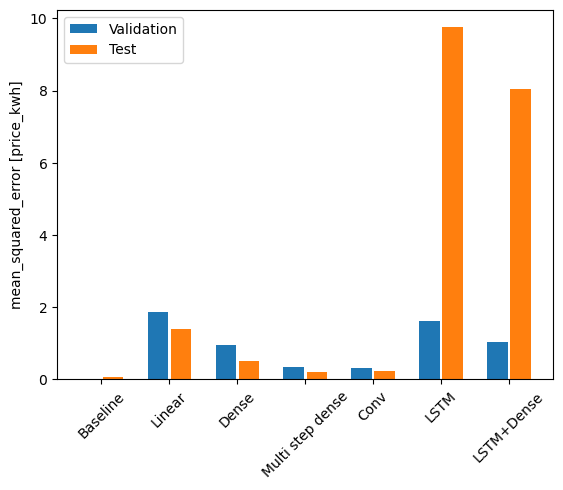

In [637]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_squared_error [price_kwh]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [ ]:
performance

{'Baseline': [0.060828596353530884, 0.060828596353530884],
 'Linear': [3.0819687843322754, 3.0819687843322754],
 'Dense': [0.9938585162162781, 0.9938585162162781],
 'Multi step dense': [0.5095612406730652, 0.5095612406730652],
 'Conv': [3.898261308670044, 3.898261308670044],
 'LSTM': [6.040222644805908, 6.040222644805908],
 'LSTM+Dense': [12.237835884094238, 12.237834930419922]}

In [ ]:
lstm_model.metrics_names

['loss', 'mean_squared_error']

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 0.0608
Linear      : 3.0820
Dense       : 0.9939
Multi step dense: 0.5096
Conv        : 3.8983
LSTM        : 6.0402
LSTM+Dense  : 12.2378


In [627]:
predictions = lstm_model.predict(my_window.train)

9/9 [==============================] - 0s 10ms/step


In [628]:
predictions.shape

(288, 1)

In [631]:
train_df.shape

(298, 10)

In [624]:
def reverse_normalization(df):
    return df*std["price_kwh"]+mean["price_kwh"]

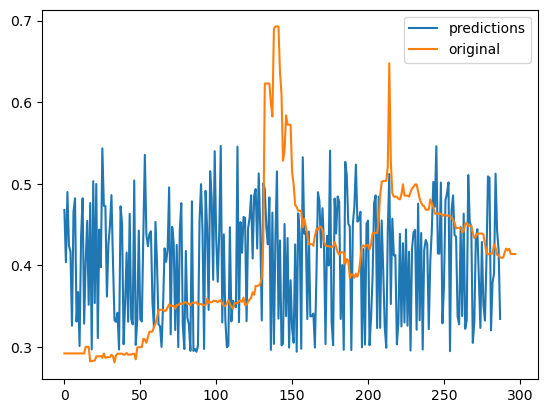

In [630]:
plt.plot(reverse_normalization(predictions.flatten()), label = "predictions")
plt.plot(reverse_normalization(train_df["price_kwh"].values), label = "original")
plt.legend()

In [ ]:
columns = ["first", "second", "third"]
train_df = pd.DataFrame([[11,12,13], [21,22,23], [31,32,33], [41, 42,43], [51,52,53]], columns = columns)
test_df = pd.DataFrame([[11,12,13], [21,22,23], [31,32,33]], columns = columns)
val_df = pd.DataFrame([[11,12,13], [21,22,23], [31,32,33]], columns = columns)
train_df

,first,second,third
0,11,12,13
1,21,22,23
2,31,32,33
3,41,42,43
4,51,52,53


In [ ]:
test = WindowGenerator(input_width = 2, label_width = 2, shift= 1, train_df=train_df, val_df=val_df,test_df=test_df, label_columns=['third'])

In [ ]:
X_train, y_train = test.example
X_train

<tf.Tensor: shape=(3, 2, 3), dtype=float32, numpy=
array([[[11., 12., 13.],
        [21., 22., 23.]],

       [[31., 32., 33.],
        [41., 42., 43.]],

       [[21., 22., 23.],
        [31., 32., 33.]]], dtype=float32)>

In [ ]:
y_train

<tf.Tensor: shape=(3, 2, 1), dtype=float32, numpy=
array([[[23.],
        [33.]],

       [[43.],
        [53.]],

       [[33.],
        [43.]]], dtype=float32)>

In [ ]:
CONV_WIDTH = 10
my_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=CONV_WIDTH,
    shift=1,
    label_columns=['price_kwh'],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

my_window